# **Cargar API de Kaggle**

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedroaguilarenc","key":"4587cb967905d9db6684484dc884cfec"}'}

# **Configurar la autenticación de la API de Kaggle y poder descargar datasets**

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Descargar un archivo ZIP con los datos de entrenamiento y prueba.**

In [11]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:13<00:00, 68.9MB/s]
100% 812M/812M [00:13<00:00, 63.9MB/s]


# **Extrae el contenido del dataset completo en el directorio actual**

In [12]:
!unzip -qq dogs-vs-cats.zip

# **Extrae solo los datos de entrenamiento**

In [13]:
!unzip -qq train.zip

# **Separar las imágenes en conjuntos de entrenamiento, validación y prueba.**

In [14]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# **Construcción del modelo**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# **Arquitectura de la CNN**

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

# **Configurando el modelo para el entrenamiento**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# **Usando image_dataset_from_directory para leer imágenes**


In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# **Formas de los datos y las etiquetas generadas por el conjunto de datos**

In [11]:
for data, labels in train_dataset:
    print("data batch shape:", data.shape)
    print("labels batch shape:", labels.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# **Entrenar el modelo**

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.5090 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5242 - loss: 0.6978 - val_accuracy: 0.5850 - val_loss: 0.6863
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5556 - loss: 0.6901 - val_accuracy: 0.5030 - val_loss: 0.6938
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.5512 - loss: 0.6837 - val_accuracy: 0.5550 - val_loss: 0.6802
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6282 - loss: 0.6600 - val_accuracy: 0.6470 - val_loss: 0.6251
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6626 - loss: 0.6210 - val_accuracy: 0.5900 - val_loss: 0.6541
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6788 - loss: 0.6052 - val_accuracy: 0.6540 - val_loss: 0.6159
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6954 - loss: 0.5802 - val_accuracy: 0.6850 -

# **Gráficar la pérdida y la precisión del modelo sobre los datos de entrenamiento y validación**

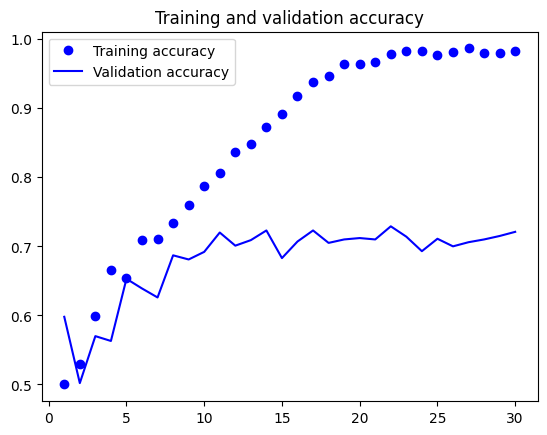

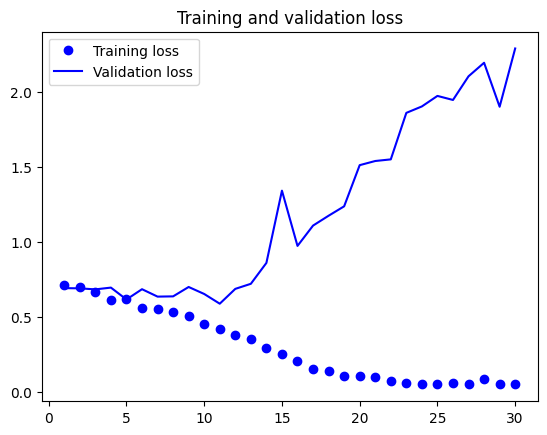

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# **Evaluación del modelo**

In [13]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6819 - loss: 0.5766
Test accuracy: 0.702


# **Aumento de datos**

**Definir una etapa de aumento de datos para agregar a un modelo de imagen**

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Muestra algunas imágenes de entrenamiento aumentadas aleatoriamente**

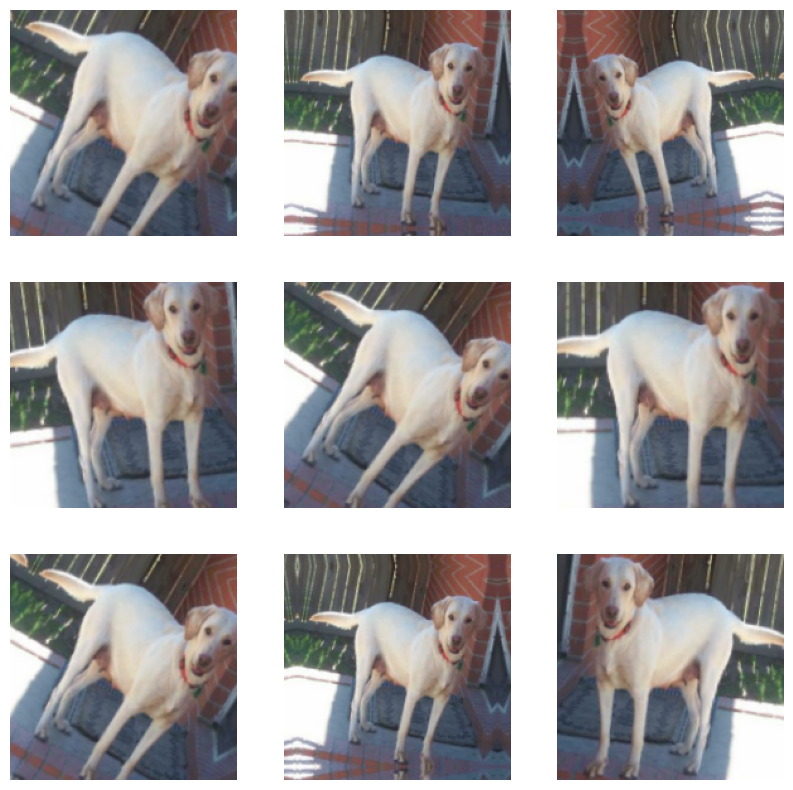

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Contruir y entrenar el modelo**

In [41]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [42]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_dataset,
epochs=80,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.4995 - loss: 0.7344 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5019 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5568 - loss: 0.6871 - val_accuracy: 0.5750 - val_loss: 0.6720
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6073 - loss: 0.6722 - val_accuracy: 0.6290 - val_loss: 0.6436
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6248 - loss: 0.6593 - val_accuracy: 0.6290 - val_loss: 0.6616
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6383 - loss: 0.6511 - val_accuracy: 0.6560 - val_loss: 0.6118
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6662 - loss: 0.6182 - val_accuracy: 0.6630 - val_loss: 0.5925
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6637 - loss: 0.6237 - val_accuracy: 0.6820 - v

In [43]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8572 - loss: 0.4485
Test accuracy: 0.850


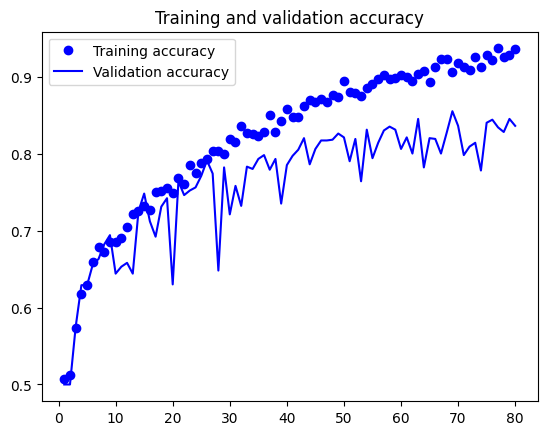

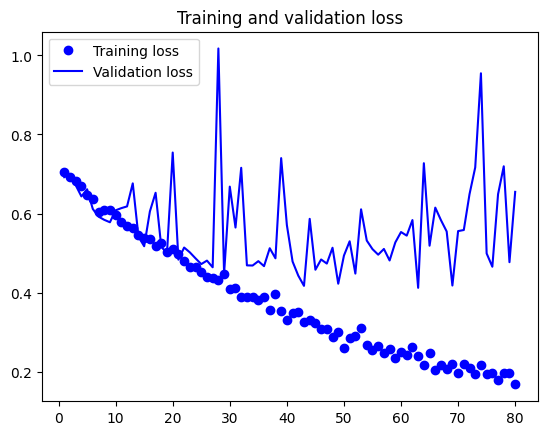

In [44]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# **Aprovechar un modelo entrenado previamente**

## **Extracción de características con un modelo preentrenado**

**Instanciación de la base convolucional VGG16**

In [12]:
from tensorflow import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Arquitectura del model VGG16**

In [3]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Extracción rápida de características sin aumento de datos**

In [14]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

**Definición y entrenamiento del clasificador densamente conectado**

In [16]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8502 - loss: 68.6850 - val_accuracy: 0.9680 - val_loss: 4.8010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9693 - loss: 4.3242 - val_accuracy: 0.9550 - val_loss: 8.6964
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9825 - loss: 2.6919 - val_accuracy: 0.9760 - val_loss: 3.8528
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9902 - loss: 1.5223 - val_accuracy: 0.9790 - val_loss: 3.8348
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9897 - loss: 1.2608 - val_accuracy: 0.9740 - val_loss: 4.3951
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9978 - loss: 0.1464 - val_accuracy: 0.9640 - val_loss: 7.1092
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9957 - loss: 0.2802 - val_accuracy: 0.9760 - val_loss: 4.1375
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.5876 - val_accuracy: 0.9740 - val_los

**Métricas de entrenamiento y validación**

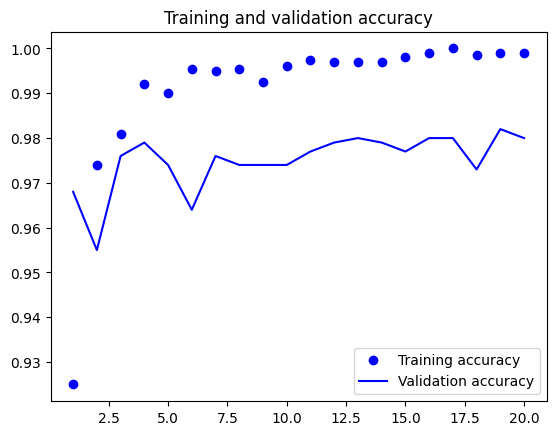

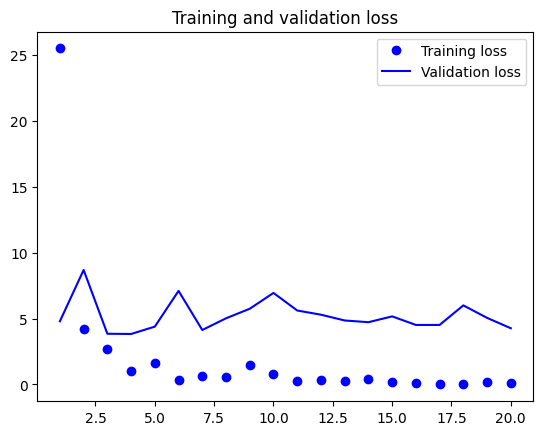

In [17]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

 **Extracción de características con aumento de datos**

**Instanciación y congelación de la base convolucional VGG16**

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Añadiendo una etapa de ampliación de datos y un clasificador a la base convolucional**

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.8221 - loss: 47.1590 - val_accuracy: 0.9690 - val_loss: 3.7484
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.9471 - loss: 5.8864 - val_accuracy: 0.9760 - val_loss: 3.9655
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9539 - loss: 6.3002 - val_accuracy: 0.9740 - val_loss: 3.7318
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.9608 - loss: 4.1825 - val_accuracy: 0.9770 - val_loss: 3.4310
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.9633 - loss: 4.4135 - val_accuracy: 0.9810 - val_loss: 3.0075
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9722 - loss: 3.2502 - val_accuracy: 0.9720 - val_loss: 3.9406
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9780 - loss: 3.0369 - val_accuracy: 0.9760 - val_loss: 3.7611
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9689 - loss: 2.9297 - val_acc

**Gráfica de parámetros**

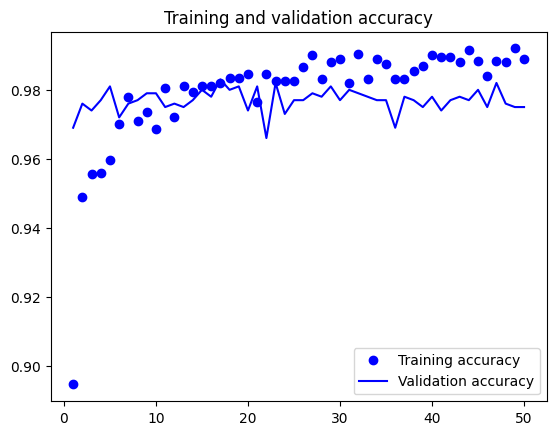

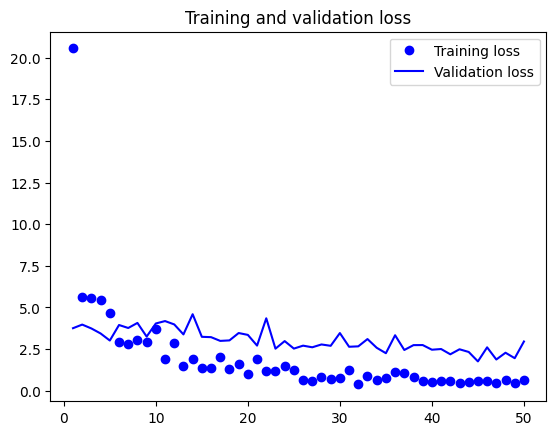

In [34]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluación del modelo**

In [35]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9777 - loss: 2.5911
Test accuracy: 0.977


## **Ajuste Fino con un modelo preentrenado**

**Agregar nuestra red personalizada sobre una red base ya entrenada**

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

**Congelar la red base**

In [17]:
conv_base.trainable = False

**Entrenar solo la parte agregada**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Congelar todas las capas menos las ultimas cuatro.**

In [5]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

**Entrenamos de forma conjunta con las capas superiores**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)